# Tensor Networks and Quantum Simulations
# Tutorial 1

Perimeter Institute

Quantum and AI Career Trajectories Mini-Course: Computational Methods and their Applications

May 9, 2023

In [2]:
import numpy as np
import tensornetwork as tn
import scipy as sp
import time
import pickle
import matplotlib.pyplot as plt

## Tensor contractions

The heart of every tensor network library is its contraction routine, a function that can be used to calculate

\begin{equation}
C_{i,l} = \sum_{j,k} A_{i,j,k} B_{l,k,j}
\end{equation}

efficiently. This can be done by explicitly calculating this sum:

In [3]:
t = time.time();

a = np.random.rand(100,4,102);
b = np.random.rand(50,102,4);

c = np.zeros((100,50));
for i in range(100):
    for j in range(4):
        for k in range(102):
            for l in range(50):
                c[i,l] += a[i,j,k]*b[l,k,j]
print( "Time: {} seconds".format(time.time()-t) )

Time: 2.131732940673828 seconds


But this is slow (and very long to write out). Much more efficient is to use a series of reshapes/permutations/matrix multiplications. The bulk of the work will then be done using the system's highly optimized BLAS libarary:

In [4]:
a = np.random.rand(100,4,102)
b = np.random.rand(50,102,4)

t = time.time()
a_r = np.reshape(a,(100,4*102))
b_t = np.transpose(b,(2,1,0))
b_tr = np.reshape(b_t,(4*102,50))

c = a_r@b_tr
print( "Time: {} seconds".format(time.time()-t) )

Time: 0.007953166961669922 seconds


## The `ncon` function

While the reshape-permute-multiply approach works, it's both tedious and error prone. There is a far more convenient function that does these operations automatically, called `ncon` (https://arxiv.org/abs/1402.0939).  `ncon` (short for Networks CONtractor) defines an interface for the contraction of complicated tensor networks. The minimal input to `ncon` is a list of tensors, and a list of a list of contraction indices. If `A,B` are tensors of order 3, then a possible input would look the following way:
```
result = ncon([A,B],[[-1,1,2],[-2,2,1]])
```
The corresponding diagram is given by 
 <h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1WgMlOTtOJA055978A4Pi5onytaiRZ5cG" width="200">
 </h2>

The second input to argument to `ncon` above is a list of a list of integers. Each integer there can be positive or negative (0 is not allowed). The first list in the second argument specifies one such integer label for each index of tensor A, the second list one integer label for each index of tensor B. 

Negative labels specify uncontracted indices, and should only appear once. Positive indices specify contracted indices, and have to be appear **exactly twice**. `ncon` will then perform the specified contraction. The bond with the lowest positive integer will be contracted first, followed by the bond with the next largest number, a.s.o. until all contractions have been carried out. 

The indices of the resulting tensor will the ordered such that the index with label -1 is the first index, index with label -2 the second, a.s.o.

In [5]:
t = time.time()
c = tn.ncon([a,b],[[-1,1,2],[-2,2,1]]);
print( "Time: {} seconds".format(time.time()-t) )

Time: 0.004661083221435547 seconds


Every entry in the list of tensors has a corresponding entry in the list of legs:

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1QjhtyqDeImp-Hv33uhScGQ0rpm61nnom" width="200">
 </h2>

if a leg-label occurs twice then it will be contracted over. Negative labels correspond with the legs of the output tensor. In this contraction, we tell ncon to contract the second leg of A with the third leg of B, and to contract the third leg of A with the second leg of B. 

**Exercise 1**: Code up the following contraction diagram

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1JcJ1ep8AZNgEZCCr1idYtsag4gHIu17Z" width="300">
 </h2>

In [6]:
A = np.random.rand(1,2,3)
B = np.random.rand(3,1)
C = np.random.rand(3,2,4)
D = np.random.rand(3,4)

### Solution to Exercise 1: ###
tn.ncon([A,B,C,D],[[1,2,3],[4,1],[4,2,5],[3,5]])

array(2.40350617)

## Contraction order

`ncon` still works behind the scenes by succesively permuting/reshaping/multiplying pairs of matrices, and the order that this is done can greatly influence the computational cost! Remember that the cost of muliplying a matrix of dimensions $(m,k)$ with one of dimensions $(k,l)$ scales as $mkl$.

Consider the following contraction diagram

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1fX4W_Pr_tRDPHCQYFgWHJTzYlbGriO1_" width="250">
 </h2>

If the tensors $A$ and $C$ have dimensions $(D,p,D)$ then multiplying the tensors $A$ and $C$ together has a computational cost scaling as $D^4$.

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1ocN263BnZ3rPB_G2wB3On367OuCpTekz" width="180">
 </h2>

On the other hand if we first contract tensor $A$ with $B$ and only then contract with $C$, then the total computational cost scales as $D^3$!

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=16S97qoqV42Ihj6W_EgP-FacFnIbOoEqa" width="250">
 </h2>

It is therefore important to have control over the contraction ordering, which `ncon` provides by either contracting the legs with the lowest index-label, or by following a user-defined order.

In [7]:
def contract_network(order):
    
    A = np.random.rand(100,2,100)
    B = np.random.rand(100,100)
    C = np.random.rand(100,2,100)

    t = time.time()
    D = tn.ncon([A,B,C],[[2,1,-2],[3,2],[3,1,-1]],con_order=order)
    print( "For order {}: time = {} seconds".format(order, time.time()-t) )

contract_network([1,2,3])

For order [1, 2, 3]: time = 3.564274311065674 seconds


**Exercise 2**: You can accelerate the contraction above by playing with the `order` parameter! Try to find a faster contraction path.

In [8]:
contract_network([3,1,2])

For order [3, 1, 2]: time = 0.009155035018920898 seconds


Finding the optimal contraction order is in general an NP-complete problem. Nevertheless, if we only have a handfull of tensors then it can be quickly found. For large networks, people generally use heuristic approaches to find good contraction orders. 

The `tensornetwork` library offers the `ncon_solver` interface, which uses such an approach to find good contractions orders. From its solution we can see that it's faster to contract first leg 3, then legs 1 and 2.

In [9]:
A = np.random.rand(100,2,100)
B = np.random.rand(100,100)
C = np.random.rand(100,2,100)

# the original slow contraction
order, cost, is_optimal = tn.contractors.ncon_solver([A,B,C],[[2,1,-2],[3,2],[3,1,-1]])
print(f" the best order is {order}\n cost of the contraction in log10(FLOPS) = {cost}\n is the order optimal? {is_optimal}")

 the best order is [3, 1, 2]
 cost of the contraction in log10(FLOPS) = 6.6020599913279625
 is the order optimal? True


## Free particle on a ring

In this section we will find the groundstate of a free particle hopping around on a ring, and then use ncon to calculate expectation values. The Hamiltonian of this system is given by 

$$H = \sum_{i=0}^{N-1} -T_i + 2 K_i$$

with the hopping operator 
$$ T_i = c^+_{i} c^-_{(i+1)mod N} + c^+_{(i+1) mod N} c^-_{i} $$
and a local potential
$$ K_i = c^+_i c^-_i $$

$T_i$ and $K_i$ have the following matrix (or tensor) representations:

In [10]:
T = np.zeros((2,2,2,2))

T[0,1,1,0] = 1
T[1,0,0,1] = 1

K = np.diag([0,1])

**Exercise 3**: implement the full hamiltonian $H = \sum_i - T_i + 2 K_i$ assuming periodic boundary conditions for a system of size 6, using `ncon`.

In [11]:
H = np.zeros((2,2,2,2,2,2,2,2,2,2,2,2))
eye = np.diag([1,1])

H += tn.ncon([2*K,eye,eye,eye,eye,eye],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H += tn.ncon([eye,2*K,eye,eye,eye,eye],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H += tn.ncon([eye,eye,2*K,eye,eye,eye],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H += tn.ncon([eye,eye,eye,2*K,eye,eye],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H += tn.ncon([eye,eye,eye,eye,2*K,eye],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H += tn.ncon([eye,eye,eye,eye,eye,2*K],[[-1,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])

H -= tn.ncon([T,eye,eye,eye,eye],[[-1,-2,-7,-8],[-3,-9],[-4,-10],[-5,-11],[-6,-12]])
H -= tn.ncon([T,eye,eye,eye,eye],[[-2,-3,-8,-9],[-1,-7],[-4,-10],[-5,-11],[-6,-12]])
H -= tn.ncon([T,eye,eye,eye,eye],[[-3,-4,-9,-10],[-1,-7],[-2,-8],[-5,-11],[-6,-12]])
H -= tn.ncon([T,eye,eye,eye,eye],[[-4,-5,-10,-11],[-1,-7],[-2,-8],[-3,-9],[-6,-12]])
H -= tn.ncon([T,eye,eye,eye,eye],[[-5,-6,-11,-12],[-1,-7],[-2,-8],[-3,-9],[-4,-10]])
H -= tn.ncon([T,eye,eye,eye,eye],[[-6,-1,-12,-7],[-2,-8],[-3,-9],[-4,-10],[-5,-11]])


The hamiltonian commutes with the translation operator, so different eigenvectors of the hamiltonian will have different momenta. The translation operator $T$ has the following diagrammatic form:
<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1Yq--W7FE2L8v6tQsBFGAFDblgHiVJIRY" width="700">
 </h2>

If we diagonalize the product $HT$, we obtain simultaneous eigenmodes and eigenvalues of $H$ and $T$. 

**Exercise 4**: Use the diagram above and the `ncon` function to compute the translation operator by one site, $T$, and compute the eigenvalues of  $TH$.

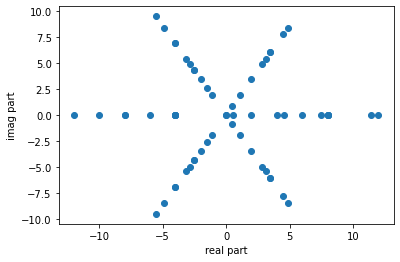

Text(0, 0.5, 'E(k)')

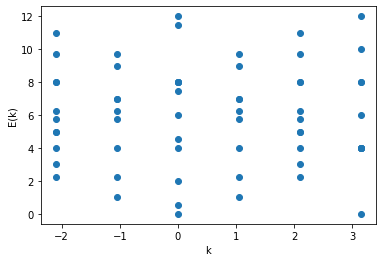

In [12]:
Translation = tn.ncon([eye,eye,eye,eye,eye,eye],[[-2,-7],[-3,-8],[-4,-9],[-5,-10],[-6,-11],[-1,-12]])
T = np.reshape(Translation,(2*2*2*2*2*2,2*2*2*2*2*2))
(vals,vecs) = np.linalg.eig(T@np.reshape(H,(2*2*2*2*2*2,2*2*2*2*2*2)))

vals = np.sort(vals)
plt.scatter(np.real(vals), np.imag(vals))
plt.xlabel('real part')
plt.ylabel('imag part')

angles = np.angle(vals)
absvals = np.abs(vals)
plt.show()
plt.scatter(angles, absvals)
plt.xlabel('k')
plt.ylabel('E(k)')


**Question**: How does the spectrum change if we diagonalize $TTH$ instead, or $TTTH$?

## Matrix product states

Matrix product states are simple chains of tensors

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1w5Ov5wKaIso8GHVMlBGGAwPLK-vwGG3-" width="700">
 </h2>

The ordering of the three legs of each tensor is given by the red integers in the following diagram:
 <h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1Hmgw9O57wJQiKvMemeCJ4-3Vb9aCljCf" width="300">
 </h2>

 The leg with index "2" above is called "physical leg" with dimension $d_i$, and the horizant two legs (with indices "1" and "3") are called ancillary or auxilliary legs with bond dimensions $D_{i-1}, D_i$



In [13]:
# define random mps tensors
t_1 = np.random.rand(1,2,2)
t_2 = np.random.rand(2,2,4)
t_3 = np.random.rand(4,2,4)
t_4 = np.random.rand(4,2,4)
t_5 = np.random.rand(4,2,2)
t_6 = np.random.rand(2,2,1)

state = [t_1,t_2,t_3,t_4,t_5,t_6]

The `tensornetwork` library provides both a more convenient constructor and a proper "`FiniteMPS`" type:

In [14]:
# this creates a random new mps
rank = 6
phys_dim = 2
phys_dims = [2 for _ in range(rank)]
bond_dims = [4 for _ in range(rank-1)]
fmps = tn.FiniteMPS.random(d = phys_dims,D = bond_dims, dtype = np.float32, canonicalize=True)

# this creates one from our list of tensors
fmps = tn.FiniteMPS(state)

The advantage of matrix product states is that they provide a way of parametrizing states in a $d^n$ dimensional hilbert space, with a number of parameters that only scale linearly in $n$! They describe only a small corner of the hilbert space, where the size of this corner is intimitaly related to the dimension of the leg that we contract over (in our example this "bond dimension" is 4). MPS shine when they can efficiently describe a target state using a small bond dimension, for example when approximating a groundstate of a local, gapped hamiltonian in 1d. 

### Computing the norm of an MPS

We can calculate the norm of the MPS by evaluating the following contraction diagram

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1VuKhzOuFVwzafAExZiVAg2dcNxkuXixl" width="700">
 </h2>

 Dashed lines at the left and right end denote contractions over an index of size 1, i.e. it can be ommited. 

 The full contraction can be carried out iteratively, e.g. from left to right, following the pattern shown below:
<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1ARokR6gGHXsok_4L4ulU-ng7SLV4ZpZc" width="400">
 </h2>



In [15]:
left = np.ones((1,1))
for t in state:
    left = tn.ncon([left,t,tn.conj(t)],[[1,2],[2,3,-2],[1,3,-1]])
left

array([[1653.82610695]])

The approach we used here was to start from the left, and every time add a single tensor "transfer operator". 

We could also have started from the right hand side in an analogous fashion. In general, one often faces the situation where one needs to contract such a diagram partially. In the above case for example, it could mean that one needs to contract the network up to the tensors at site 3, $t_3$ and $\bar t_3$. The diagram would then be simplified into 
<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1FPGoF2cF_2UuXsNIrZRnkOnFKr0ofIVu" width="250">
 </h2>
 with $i=3$. The tensors $L_i$ and $R_i$ are called *environment* tensors of site $i$ for the norm of the MPS. Depending on the actual network one is interested in, environment tensors can become quite complex. In the case we're considering here, they are order-2 tensors, i.e. matrices. 

 Many tensor network algorithms are formulated as local optimization problems, i.e. tensors are optimized one after the other (sequentially) according to some cost function, given by a tensor network. A crucial part of the optimization is the ability to *efficiently* compute the environments of the corresponding tensors.

**Exercise 5**: Construct the $L$ and $R$ tensors for the 4th tensor (at index 3) of the "state" MPS

In [16]:
left = np.ones((1,1))
right = np.ones((1,1))

### Solution to Exercise 5 ###

# construct the correct L and R tensors for state[3]:
for loc in range(3):
    left = tn.ncon([left,state[loc],tn.conj(state[loc])],[[1,2],[2,3,-2],[1,3,-1]])

for loc in reversed(range(4,len(state))):
    right = tn.ncon([right,state[loc],tn.conj(state[loc])],[[1,2],[-1,3,1],[-2,3,2]])

tn.ncon([left,state[3],tn.conj(state[3]),right],[[1,2],[2,3,4],[1,3,5],[4,5]])

array(1653.82610695)

### Gauge transformation


The norm-environment above (and often other environments on more complicated tensor networks) can potentially be rank-defficient. This property can, and should, be exploited to reduce the computational burden of an algorithm. In practice, it is often even mandatory to exploit the low-rank structure in order to stabilize the optimization. An important tool in the MPS toolbox are *gauge transformations*, which can be used to reveal the low-rank structure of an MPS tensor.

Gauge transformations in MPS language are local transformations of the MPS tensors which leave the global state invariant. 
In the following we insert a resolution of the identity on one bond of the MPS. The global states is trivially invariant under this change. 


<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1k8JGt-gkS84TaICCa4jzln_PFytYOq43" width="900">
 </h2>

Another example would be the use of the QR decomposition to decompose tensor $t_i$ into an orthogonal and an upper-triangular matrix,

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=10Fz_dv3tJC44L7hdNanG0WPLK6RZEqFl" width="400">
 </h2>

such that

<h2 align="center">
<img src="https://drive.google.com/uc?export=view&id=1YA9RIj1ys7z06VXnKC4RjqCmkj4XmoBt" width="250">
</h2>

The QR decomposition is a particular useful tool, and it can be used to bring an MPS into central canonical form with respect to a given site $i$. This means that all MPS tensors to the left of site $i$ are left-isometric, and all tensors to the right of site $i$ are right isometric. An immediate advantage of this gauge is that the left and right norm-environments $L_i$ and $R_i$ above become identities. 

In [17]:
for i in range(3):
    t = tn.Node(state[i]) # a node is a backend-agnostic tensor container
    (q,r) = tn.split_node_qr(t,left_edges=[t[0],t[1]],right_edges=[t[2]])
    state[i] = q.tensor
    state[i+1] = tn.ncon([r.tensor,state[i+1]],[[-1,1],[1,-2,-3]])

for i in reversed(range(4,len(state))):
    t = tn.Node(state[i])
    (r,q) = tn.split_node_rq(t,left_edges=[t[0]],right_edges=[t[1],t[2]])
    state[i] = q.tensor;
    state[i-1] = tn.ncon([state[i-1],r.tensor],[[-1,-2,1],[1,-3]])
    
tn.ncon([state[3],tn.conj(state[3])],[[1,2,3],[1,2,3]])

array(1653.82610695)

This gauge is often referred to as central canonical gauge. The `tensornetwork` library contains a utility function to move this center site around, using the `mps.position` function.

In [18]:
fmps = tn.FiniteMPS(state) # create a finite mps object and normalize the tensors
fmps.position(1) # the second tensor is now the "center site"
tn.ncon([fmps.tensors[0],tn.conj(fmps.tensors[0])],[[1,2,-2],[1,2,-1]]) # the site to the left should be a left isometry!

array([[ 1.00000000e+00, -6.17395962e-17],
       [-6.17395962e-17,  1.00000000e+00]])

In [19]:
tn.ncon([fmps.tensors[2],tn.conj(fmps.tensors[2])],[[-1,2,1],[-2,2,1]]) # every site to the right should be a right isometry

array([[ 1.00000000e+00, -8.15862135e-17, -2.60208521e-18,
         4.77048956e-18],
       [-8.15862135e-17,  1.00000000e+00, -1.64798730e-17,
        -2.08166817e-17],
       [-2.60208521e-18, -1.64798730e-17,  1.00000000e+00,
         5.55111512e-17],
       [ 4.77048956e-18, -2.08166817e-17,  5.55111512e-17,
         1.00000000e+00]])